In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import pandas as pd
from matplotlib import pyplot as plt
from shapely import wkt
from geopandas import GeoDataFrame

In [2]:
CABA = gpd.read_file('datos/mapas/barrios.shp')
CABA.head()

,BARRIO,COMUNA,PERIMETRO,AREA,geometry
0,CHACARITA,15.0,7725.695228,3.118101e+06,"POLYGON ((-58.4528200492791 -34.5959886570639,..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,"POLYGON ((-58.4655768128541 -34.5965577078058,..."
2,VILLA CRESPO,15.0,8132.699348,3.613584e+06,"POLYGON ((-58.4237529813037 -34.5978273383243,..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,"POLYGON ((-58.4946097568899 -34.6148652395239,..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,"POLYGON ((-58.4128700313089 -34.6141162515854,..."


In [3]:
# La mantengo por las dudas pero no  creo que sea necesaria

def obtener_poligono(multi):
    l =[]
    for x in multi.split(')'):
        poligono = []
        for y in x.split(','):
            if 'MULTIPOLYGON ' in y:
                y = y.replace('MULTIPOLYGON ', '')
            if 'POLYGON ' in y:
                y = y.replace('POLYGON ', '')
            if '(' in y:
                y = y.replace('(', '')
            if len(y) < 5:
                continue
            lon, lat = y.split()
            poligono.append((float(lon), float(lat)))
        l.append(Polygon(poligono))
    return MultiPolygon(l)

In [7]:
#CABA.loc[:,'geometry'] = CABA.loc[:,'geometry'].apply(lambda x: obtener_poligono(x))

In [5]:
#CABA.head()

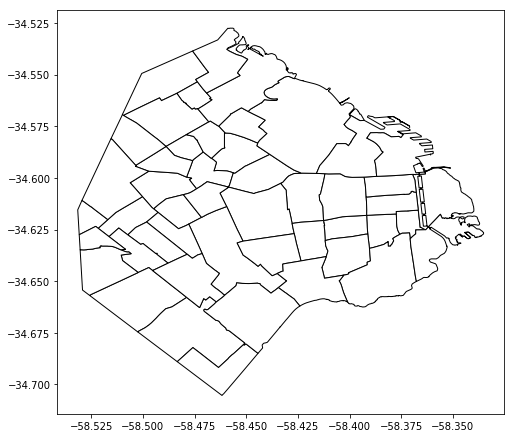

In [8]:
CABA.plot(color='white', edgecolor='black',figsize=(8,8))
plt.savefig('informe/imagenes/caba.png')
plt.show()

In [5]:
#propiedades = pd.read_csv('properati.csv')
propiedades = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/properati.csv')

In [6]:
solo_capital = propiedades.loc[(propiedades.state_name == 'Capital Federal') & (propiedades.lat.notnull()) & (propiedades.lon.notnull()),:]
solo_capital = solo_capital.loc[((solo_capital.lat <= -34.515) & (solo_capital.lat >= -34.750)),:]
solo_capital = solo_capital.loc[((solo_capital.lon <= -58.300) & (solo_capital.lon >= -58.550)),:]

In [7]:
solo_capital.loc[:,'geometry'] = solo_capital.loc[:,['lat','lon']].apply(lambda y: Point(y[1],y[0]), axis = 1)
solo_capital.head(1)

,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,...,property_type,rooms,state_name,superficie,Year,Month,Year_created,Month_created,cantidad_meses_publicado,geometry
0,2012-08-08,NaN,NaN,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,NaN,...,apartment,3.0,Capital Federal,102.0,2013,7,2012,8,11,POINT (-58.464514 -34.561208)


In [9]:
solo_capital['price_aprox_usd'].describe()

count    7.599450e+05
mean     2.219684e+05
std      3.509063e+05
min      0.000000e+00
25%      9.200000e+04
50%      1.350000e+05
75%      2.260000e+05
max      4.654544e+07
Name: price_aprox_usd, dtype: float64

In [10]:
#Tomo el valor del 25% y 75%
minimo = 9.2 * (10 ** 4)
maximo = 2.26 * (10 ** 5)
print(minimo,maximo)

(92000.0, 225999.99999999997)


In [11]:
cant_colores = 3

precios = []
for i in range(cant_colores + 1):
    precios.append(minimo + (maximo - minimo) * i / cant_colores)
precios

[92000.0, 136666.66666666666, 181333.3333333333, 225999.99999999997]

In [12]:
#Me fijo que esten en Capital, porque algunos datos estan mal
solo_capital.loc[:,'contiene'] = solo_capital.loc[:,'geometry'].apply(lambda x: CABA.contains(x).any())
solo_capital.head(1)

,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,...,rooms,state_name,superficie,Year,Month,Year_created,Month_created,cantidad_meses_publicado,geometry,contiene
0,2012-08-08,NaN,NaN,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,NaN,...,3.0,Capital Federal,102.0,2013,7,2012,8,11,POINT (-58.464514 -34.561208),True


In [13]:
solo_capital = solo_capital.loc[solo_capital.contiene,:]

In [14]:
prop = []
for i in range(cant_colores):
    prop.append(solo_capital.loc[(solo_capital.price_aprox_usd >= precios[i]) & \
                                (solo_capital.price_aprox_usd < precios[i + 1]),['geometry','price_aprox_usd']])

In [15]:
colores = ['green', 'yellow', 'red']  #de mas barato a mas caro

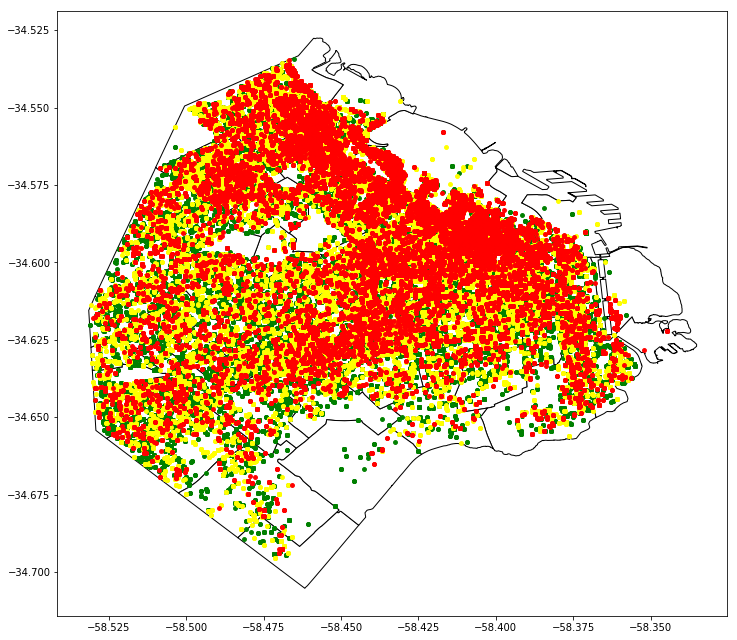

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

CABA.plot(ax=ax, color='white', edgecolor='black')

for indice,dataframe in enumerate(prop):
    dataframe = GeoDataFrame(dataframe)
    dataframe.plot(ax = ax, color = colores[indice], markersize = 15)

plt.savefig('informe/imagenes/distribucion_de_precios.png')
plt.show();

In [57]:
CABA.contains(Point(-58.516100,-34.589408)).any()

True

In [58]:
CABA.contains(Point(58.516100,-34.589408)).any()

False

## Muestro unicamente las n propiedades mas caras

In [18]:
cantidad = 150

In [19]:
solo_capital = solo_capital.loc[(solo_capital.price_aprox_usd <= maximo) & (solo_capital.price_aprox_usd >= minimo),:]

In [20]:
mas_caras = solo_capital.loc[:,['price_aprox_usd','geometry']].sort_values(by = 'price_aprox_usd', ascending = False).head(cantidad)
mas_caras.head(1)

,price_aprox_usd,geometry
161113,225995.66,POINT (-58.459324 -34.626409)


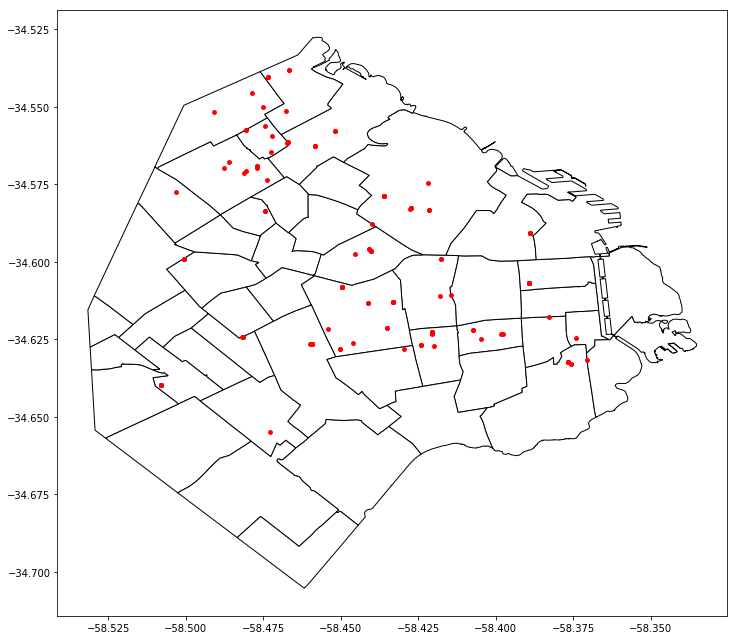

In [23]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

CABA.plot(ax=ax, color='white', edgecolor='black')

dataframe = GeoDataFrame(mas_caras)
dataframe.plot(ax = ax, color = 'red', markersize = 15)

plt.savefig('informe/imagenes/propiedades_caras.png')
plt.show();

## Muestro unicamente las n propiedades mas baratas

In [24]:
mas_baratas = solo_capital.loc[:,['price_aprox_usd','geometry']].sort_values(by = 'price_aprox_usd').head(cantidad)
mas_baratas.head(1)

,price_aprox_usd,geometry
116740,92000.0,POINT (-58.511839 -34.64666500000001)


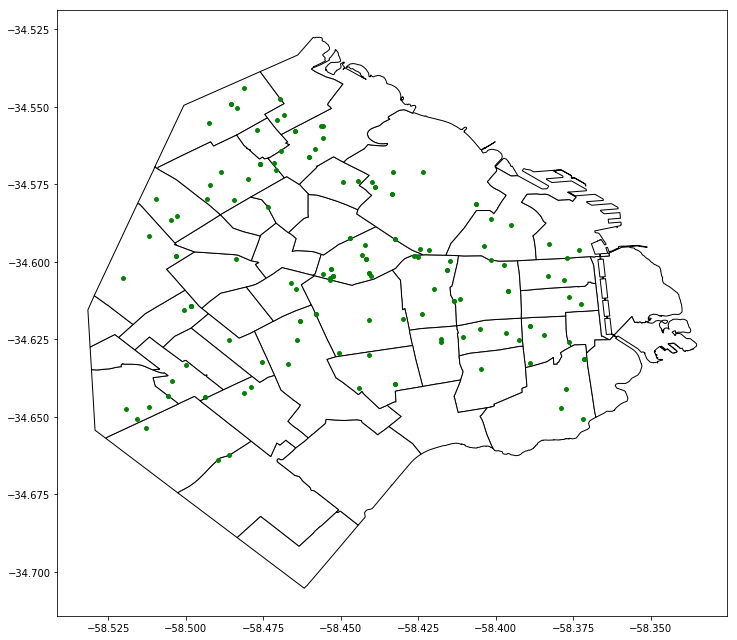

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

CABA.plot(ax=ax, color='white', edgecolor='black')

dataframe = GeoDataFrame(mas_baratas)
dataframe.plot(ax = ax, color = 'green', markersize = 15)

plt.savefig('informe/imagenes/propiedades_baratas.png')
plt.show();